In [1]:
import os
from typing import List, Optional
import sys
sys.path.insert(0, "../") #load the cellm outside of notebooks
import torch
from lightning import LightningDataModule
from cellm.data.data_scimilarity_gred import SampleCellsDataModule_disease, scDataset_disease
from torch.utils.data import Dataset, DataLoader
import pickle

from dataclasses import dataclass
import json

/home/liut61/miniforge3/envs/cellm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from rep_ct_utils import SampleCellsDataModuleCustom

# For cell type we should use train because testing samples have few cell types.

In [3]:
import random
from lightning.pytorch import Trainer, seed_everything
seed_everything(0, workers=True)
scd = SampleCellsDataModuleCustom()
global_count_sample = scd.save_ct_result

Seed set to 0


['healthy', 'COVID-19']
Training data size: (1320030, 7)
Validation data size: (1758589, 7)
Testing data size: (89109, 7)
200
354
38


In [5]:
len(global_count_sample)

0

In [6]:
import numpy as np
f1score_list = []
finalauroc_list = []
from sklearn.metrics import classification_report #1e-3, best save
from sklearn.metrics import roc_auc_score

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

from typing import Callable, Any, Dict

import lightning as L
import torch
import torchmetrics
# from pl_bolts.optimizers import LinearWarmupCosineAnnealingLR
from torch import nn

from cellm.components.cell_to_cell import CellToCellPytorchTransformer
from cellm.components.cell_to_output import CellToOutputMLP
from cellm.components.gene_to_cell import GeneToCellLinear
from cellm.components.masking import Masking
# from cellm.data.data_structures import CellSample
import pickle

from rep_ct_utils import CellClassifyModel
        
class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e3wd1e4batch32epoch50_weightaverage_dim1-epoch=36-val_accuracy=0.82.ckpt", num_genes=28231, masking_strategy=None, attn = 'linear_attn')

ig = IntegratedGradients(class_model)

2


In [7]:
class_model

CellClassifyModel(
  (gene_to_cell_encoder): GeneToCellLinear(
    (encoder): LinearModule(
      (network): Linear(in_features=28231, out_features=1024, bias=True)
    )
  )
  (cell_to_output_encoder): CellToOutputMLP(
    (encoder): MLP(
      (network): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
          (1): PReLU(num_parameters=1)
        )
        (1): Sequential(
          (0): Dropout(p=0.0, inplace=False)
          (1): Linear(in_features=512, out_features=512, bias=True)
          (2): PReLU(num_parameters=1)
        )
        (2): Linear(in_features=512, out_features=2, bias=True)
      )
    )
  )
  (loss_func): CrossEntropyLoss()
)

In [7]:
attributions_list = []
approximation_error_list = []
label_list = []


if torch.cuda.is_available():
    for i in scd.train_dataloader():
        baselines = torch.zeros_like(i.x).to('cuda')
        attributions, approximation_error = ig.attribute(i.x.to('cuda'),
                                                         baselines=baselines,
                                                         target=i.disease_label,
                                                         return_convergence_delta=True)
        attributions_list.append(attributions)
        approximation_error_list.append(approximation_error)
        label_list.append(i.disease_label.item())
    
else:
    for i in scd.train_dataloader():
        baselines = torch.zeros_like(i.x)
        attributions, approximation_error = ig.attribute(i.x,
                                                         baselines=baselines,
                                                         target=i.disease_label,
                                                         return_convergence_delta=True)
        attributions_list.append(attributions)
        approximation_error_list.append(approximation_error)
        label_list.append(i.disease_label.item())
    

In [8]:
len(scd.save_ct_result)

200

In [9]:
healthy_average = []
healthy_average_ct = [] 
disease_average = []
disease_average_ct = []
for i,j,ctl in zip(attributions_list,label_list,scd.save_ct_result):
    if j == 0:
        healthy_average.append(i.cpu().numpy().mean(axis=2)[0])
        healthy_average_ct.append(ctl[1])
    else:
        disease_average.append(i.cpu().numpy().mean(axis=2)[0])
        disease_average_ct.append(ctl[1])
        

In [10]:
import pandas as pd
import numpy as np

In [11]:
health_data = []
for i,j in zip(healthy_average, healthy_average_ct):
    df = pd.DataFrame()
    # tf_example = sklearn.preprocessing.MaxAbsScaler()
    # i = tf_example.fit_transform(i.reshape(-1,1)).T[0]
    df['data'] = i 
    df['cell_type'] =  j
    df['condition'] = 'health'
    health_data.append(df)
health_data = pd.concat(health_data)


disease_data = []
for i,j in zip(disease_average, disease_average_ct):
    df = pd.DataFrame()
    # tf_example = sklearn.preprocessing.MaxAbsScaler()
    # i = tf_example.fit_transform(i.reshape(-1,1)).T[0]
    df['data'] = i 
    df['cell_type'] = j
    df['condition'] = 'disease'
    disease_data.append(df)
disease_data = pd.concat(disease_data)

In [12]:
health_data

,data,cell_type,condition
0,1.428972e-06,non-classical monocyte,health
1,1.235890e-06,"naive thymus-derived CD4-positive, alpha-beta ...",health
2,2.228265e-06,non-classical monocyte,health
3,5.374175e-07,plasmacytoid dendritic cell,health
4,1.717891e-06,"naive thymus-derived CD4-positive, alpha-beta ...",health
...,...,...,...
95,1.163175e-06,CD14-positive monocyte,health
96,4.640189e-07,"central memory CD4-positive, alpha-beta T cell",health
97,2.713598e-06,natural killer cell,health
98,8.860437e-07,natural killer cell,health


In [13]:
disease_data['cell_type'].unique()

array(['naive thymus-derived CD4-positive, alpha-beta T cell',
       'natural killer cell', 'classical monocyte',
       'CD4-positive helper T cell',
       'naive thymus-derived CD8-positive, alpha-beta T cell',
       'conventional dendritic cell', 'plasma cell',
       'CD16-negative, CD56-bright natural killer cell, human',
       'naive B cell', 'non-classical monocyte',
       'CD8-positive, alpha-beta cytotoxic T cell',
       'central memory CD8-positive, alpha-beta T cell', nan,
       'regulatory T cell', 'B cell', 'plasmacytoid dendritic cell',
       'effector memory CD8-positive, alpha-beta T cell',
       'class switched memory B cell', 'plasmablast',
       'mucosal invariant T cell',
       'effector memory CD8-positive, alpha-beta T cell, terminally differentiated',
       'CD4-positive, alpha-beta cytotoxic T cell', 'gamma-delta T cell',
       'platelet', 'mature NK T cell', 'hematopoietic precursor cell',
       'innate lymphoid cell',
       'CD16-positive, CD56-

In [14]:
ct_map = {'naive thymus-derived CD4-positive, alpha-beta T cell':"CD4-positive T cell",
       'natural killer cell':"natural killer cell", 
        'classical monocyte':"classical monocyte",
       'CD4-positive helper T cell':"CD4-positive T cell",
       'naive thymus-derived CD8-positive, alpha-beta T cell':"CD8-positive T cell",
       'conventional dendritic cell':"conventional dendritic cell", 
          'plasma cell':"plasma cell",
       'CD16-negative, CD56-bright natural killer cell, human':"natural killer cell",
       'naive B cell':"B cell", 
          'non-classical monocyte':"non-classical monocyte",
       'CD8-positive, alpha-beta cytotoxic T cell':"CD8-positive T cell",
       'central memory CD8-positive, alpha-beta T cell':"CD8-positive T cell", 
        'nan':"nan",
       'regulatory T cell':"regulatory T cell", 
          'B cell':"B cell", 
          'plasmacytoid dendritic cell':"plasmacytoid dendritic cell",
       'effector memory CD8-positive, alpha-beta T cell':"CD8-positive T cell",
       'class switched memory B cell':"B cell", 
          'plasmablast':"plasmablast",
       'mucosal invariant T cell':"mucosal invariant T cell",
       'effector memory CD8-positive, alpha-beta T cell, terminally differentiated':"CD8-positive T cell",
       'CD4-positive, alpha-beta cytotoxic T cell':"CD4-positive T cell", 
          'gamma-delta T cell':"gamma-delta T cell",
       'platelet':'platelet',
          'mature NK T cell':"NK T cell", 
          'hematopoietic precursor cell':"hematopoietic stem cell",
       'innate lymphoid cell':"innate lymphoid cell",
       'CD16-positive, CD56-dim natural killer cell, human':"natural killer cell",
       'CD14-positive monocyte':"classical monocyte", 
          'CD4-positive, alpha-beta memory T cell':"CD4-positive T cell",
       'CD8-positive, alpha-beta memory T cell':"CD8-positive T cell",
       'CD14-low, CD16-positive monocyte':"non-classical monocyte", 
          'immature B cell':"B cell", 
          'T cell':"nan",
       'hematopoietic stem cell':"hematopoietic stem cell", 
          'neutrophil':"neutrophil", 
          'erythrocyte':"erythrocyte"
         }

In [15]:
disease_data.head()

,data,cell_type,condition
0,0.000005,"naive thymus-derived CD4-positive, alpha-beta ...",disease
1,0.000009,"naive thymus-derived CD4-positive, alpha-beta ...",disease
2,0.000002,natural killer cell,disease
3,-0.000032,classical monocyte,disease
4,0.000008,"naive thymus-derived CD4-positive, alpha-beta ...",disease


In [16]:
disease_data.index = [i for i in range(len(disease_data))]

In [17]:
import sklearn

In [18]:
disease_data['cell_type'] = [ct_map[str(i)] for i in disease_data['cell_type'].values]

In [19]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

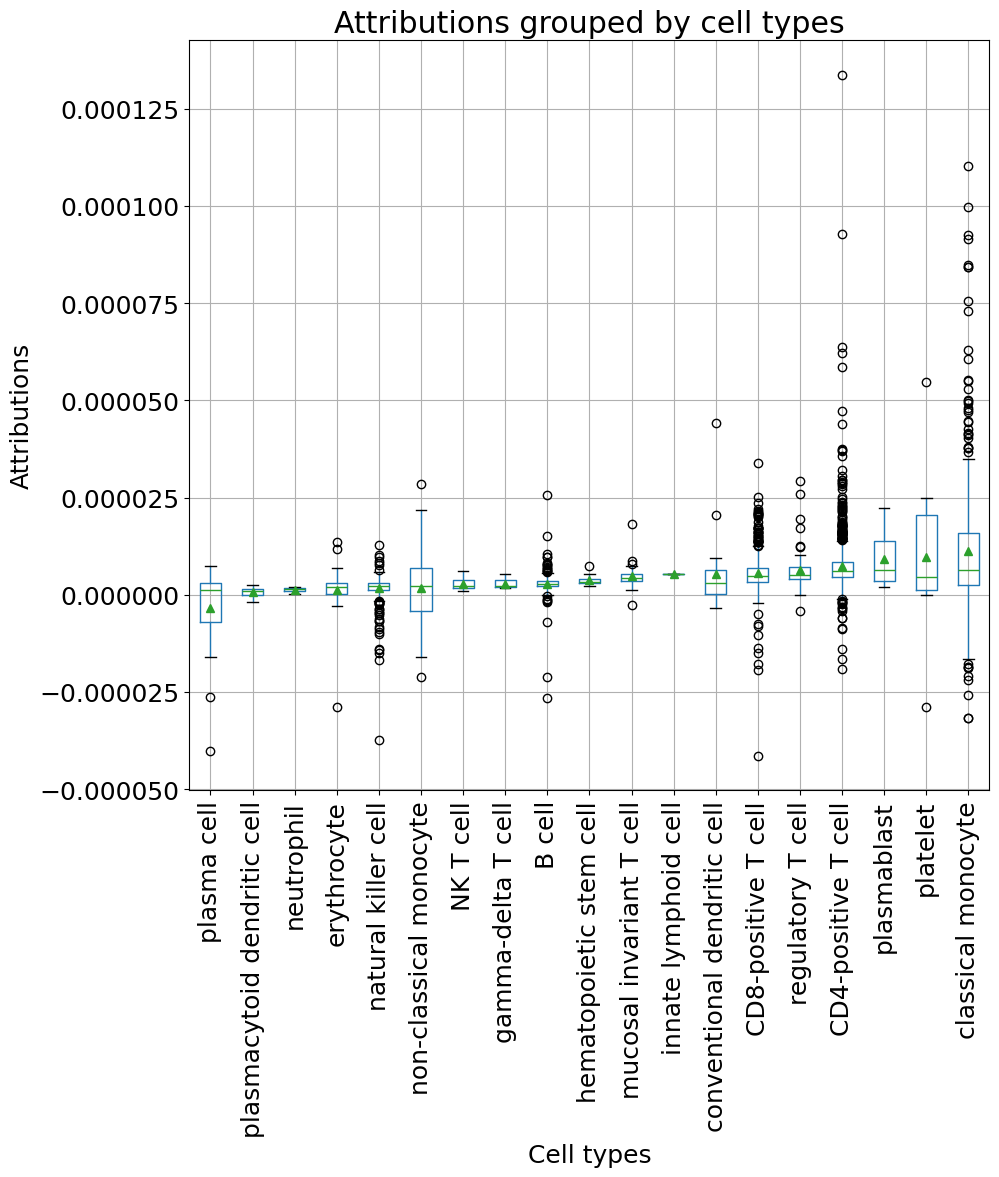

In [20]:
# Calculate means and sort

disease_data = disease_data[disease_data['cell_type'] != 'nan']

# disease_data = disease_data[disease_data['cell_type'] != 'T cell']
# disease_data = disease_data[disease_data['cell_type'] != 'B cell']
# disease_data = disease_data[disease_data['cell_type'] != 'non-classical monocyte']

means = disease_data.groupby('cell_type')['data'].mean().sort_values(ascending=True)

# Create a categorical type based on the order of means, this helps in sorting the DataFrame for plotting
disease_data['Labels'] = pd.Categorical(disease_data['cell_type'], categories=means.index, ordered=True)

disease_data.boxplot(by='Labels', column=['data'], figsize=(10,10), showmeans=True)
plt.title('Attributions grouped by cell types')
plt.suptitle('')  # Suppress the default title to only show the custom title
plt.xlabel('Cell types')
plt.xticks(rotation=90)
plt.ylabel('Attributions')
plt.show()

# For cell type per gene only

In [21]:
import random
from lightning.pytorch import Trainer, seed_everything
seed_everything(0, workers=True)
scd = SampleCellsDataModuleCustom()
global_count_sample = scd.save_ct_result

Seed set to 0


['healthy', 'COVID-19']
Training data size: (1320030, 7)
Validation data size: (1758589, 7)
Testing data size: (89109, 7)
200
354
38


In [22]:
attributions_list = []
approximation_error_list = []
label_list = []

for i in scd.train_dataloader():
    baselines = torch.zeros_like(i.x).to('cuda')
    attributions, approximation_error = ig.attribute(i.x.to('cuda'),
                                                     baselines=baselines,
                                                     target=i.disease_label,
                                                     return_convergence_delta=True)
    attributions_list.append(attributions)
    approximation_error_list.append(approximation_error)
    label_list.append(i.disease_label.item())
    

In [23]:
len(scd.save_ct_result)

200

In [24]:
healthy_average = []
healthy_average_ct = [] 
disease_average = []
disease_average_ct = []
for i,j,ctl in zip(attributions_list,label_list,scd.save_ct_result):
    if j == 0:
        healthy_average.append(i.cpu().numpy()[0,:])
        healthy_average_ct.append(ctl[1])
    else:
        disease_average.append(i.cpu().numpy()[0,:])
        disease_average_ct.append(ctl[1])

In [25]:
import pandas as pd

In [26]:
disease_average[0].shape

(100, 28231)

In [27]:
ct_map = {'naive thymus-derived CD4-positive, alpha-beta T cell':"CD4-positive T cell",
       'natural killer cell':"natural killer cell", 
        'classical monocyte':"classical monocyte",
       'CD4-positive helper T cell':"CD4-positive T cell",
       'naive thymus-derived CD8-positive, alpha-beta T cell':"CD8-positive T cell",
       'conventional dendritic cell':"conventional dendritic cell", 
          'plasma cell':"plasma cell",
       'CD16-negative, CD56-bright natural killer cell, human':"natural killer cell",
       'naive B cell':"B cell", 
          'non-classical monocyte':"non-classical monocyte",
       'CD8-positive, alpha-beta cytotoxic T cell':"CD8-positive T cell",
       'central memory CD8-positive, alpha-beta T cell':"CD8-positive T cell", 
        'nan':"nan",
       'regulatory T cell':"regulatory T cell", 
          'B cell':"B cell", 
          'plasmacytoid dendritic cell':"plasmacytoid dendritic cell",
       'effector memory CD8-positive, alpha-beta T cell':"CD8-positive T cell",
       'class switched memory B cell':"B cell", 
          'plasmablast':"plasmablast",
       'mucosal invariant T cell':"mucosal invariant T cell",
       'effector memory CD8-positive, alpha-beta T cell, terminally differentiated':"CD8-positive T cell",
       'CD4-positive, alpha-beta cytotoxic T cell':"CD4-positive T cell", 
          'gamma-delta T cell':"gamma-delta T cell",
       'platelet':'platelet',
          'mature NK T cell':"NK T cell", 
          'hematopoietic precursor cell':"hematopoietic stem cell",
       'innate lymphoid cell':"innate lymphoid cell",
       'CD16-positive, CD56-dim natural killer cell, human':"natural killer cell",
       'CD14-positive monocyte':"classical monocyte", 
          'CD4-positive, alpha-beta memory T cell':"CD4-positive T cell",
       'CD8-positive, alpha-beta memory T cell':"CD8-positive T cell",
       'CD14-low, CD16-positive monocyte':"non-classical monocyte", 
          'immature B cell':"B cell", 
          'T cell':"nan",
       'hematopoietic stem cell':"hematopoietic stem cell", 
          'neutrophil':"neutrophil", 
          'erythrocyte':"erythrocyte"
         }

In [28]:
health_data = []
count = 0
for i,j in zip(healthy_average, healthy_average_ct):
    df = pd.DataFrame(i)
    df['cell_type'] = j 
    df['condition'] = 'health'
    df['patient'] = count
    health_data.append(df)
    count += 1
health_data = pd.concat(health_data)


disease_data = []
count = 0
for i,j in zip(disease_average, disease_average_ct):
    df = pd.DataFrame(i)
    df['cell_type'] = j 
    df['condition'] = 'disease'
    df['patient'] = count
    disease_data.append(df)
    count += 1
disease_data = pd.concat(disease_data)

In [29]:
disease_data

,0,1,2,3,4,5,6,7,8,9,...,28224,28225,28226,28227,28228,28229,28230,cell_type,condition,patient
0,0.000463,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,0.000000,-0.0,-0.0,-0.000000,0.000446,0.000000,0.000000,"naive thymus-derived CD4-positive, alpha-beta ...",disease,0
1,0.000229,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.000000,-0.0,-0.0,-0.000149,0.000571,0.000265,0.000654,"naive thymus-derived CD4-positive, alpha-beta ...",disease,0
2,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.000000,0.0,-0.0,-0.000000,0.000331,0.000000,0.000000,natural killer cell,disease,0
3,-0.000000,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.000000,-0.0,-0.0,0.000000,-0.000352,0.000000,-0.000000,classical monocyte,disease,0
4,0.000035,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.000000,-0.0,-0.0,-0.000000,0.000224,0.000000,0.000000,"naive thymus-derived CD4-positive, alpha-beta ...",disease,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.000143,-0.0,-0.0,-0.000000,0.000278,0.000000,0.000000,"naive thymus-derived CD4-positive, alpha-beta ...",disease,48
96,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.000000,0.0,-0.0,-0.000000,0.000000,0.000243,0.000000,"CD16-positive, CD56-dim natural killer cell, h...",disease,48
97,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.000000,-0.0,-0.0,0.000000,0.000000,0.000000,0.001912,naive B cell,disease,48
98,0.000208,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.000000,-0.0,-0.0,0.000000,0.000000,0.000000,0.000000,naive B cell,disease,48


In [30]:
disease_data['cell_type'] = [ct_map[str(i)] for i in disease_data['cell_type'].values]

In [43]:
# #for each cell
# disease_data_mon = disease_data[disease_data['cell_type'] == 'CD14-positive monocyte']
# disease_data_mon = disease_data_mon.loc[:, ~disease_data_mon.columns.isin(['cell_type', 'condition', 'patient'])]


# for each patient
disease_data_mon = disease_data[disease_data['cell_type'] == 'classical monocyte']
disease_data_mon = disease_data_mon.loc[:, ~disease_data_mon.columns.isin(['cell_type', 'condition'])]
disease_data_mon = disease_data_mon.groupby('patient').mean()

In [44]:
disease_data_mon.columns = scd.data_module.gene_order

In [45]:
health_data

,0,1,2,3,4,5,6,7,8,9,...,28224,28225,28226,28227,28228,28229,28230,cell_type,condition,patient
0,0.000000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,-0.0,0.000000,0.0,0.000061,-0.000000,-0.0,-0.0,non-classical monocyte,health,0
1,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,-0.000163,-0.0,-0.0,"naive thymus-derived CD4-positive, alpha-beta ...",health,0
2,-0.000085,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.000000,0.0,-0.000000,-0.000232,-0.0,-0.0,non-classical monocyte,health,0
3,-0.000091,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.000000,0.0,0.000000,-0.000000,-0.0,-0.0,plasmacytoid dendritic cell,health,0
4,-0.000000,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,-0.000000,-0.0,-0.0,"naive thymus-derived CD4-positive, alpha-beta ...",health,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.000400,0.0,0.000000,-0.000544,-0.0,-0.0,CD14-positive monocyte,health,150
96,-0.000000,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.000000,0.0,0.000000,-0.000137,-0.0,-0.0,"central memory CD4-positive, alpha-beta T cell",health,150
97,-0.000000,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,-0.000220,-0.0,-0.0,natural killer cell,health,150
98,-0.000000,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.000028,0.0,0.000000,-0.000000,-0.0,-0.0,natural killer cell,health,150


In [46]:
disease_data['cell_type'].unique()

array(['CD4-positive T cell', 'natural killer cell', 'classical monocyte',
       'CD8-positive T cell', 'conventional dendritic cell',
       'plasma cell', 'B cell', 'non-classical monocyte', 'nan',
       'regulatory T cell', 'plasmacytoid dendritic cell', 'plasmablast',
       'mucosal invariant T cell', 'gamma-delta T cell', 'platelet',
       'NK T cell', 'hematopoietic stem cell', 'innate lymphoid cell',
       'neutrophil', 'erythrocyte'], dtype=object)

In [47]:
disease_data_mon

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,,,,,,,,,,,,,,,,,,,,,
0,0.000023,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,-0.000036,0.0,0.000000e+00,0.001140,0.000269,0.000000
1,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,-1.585388e-04,0.002383,0.000000,0.000000
2,-0.000033,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.047807e-05,0.000678,0.000015,0.000024
3,-0.000212,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,-8.004422e-05,0.001237,0.000264,0.000094
4,-0.000001,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,-3.327616e-05,0.002828,0.000341,0.000344
5,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,-0.000916,0.0,0.000000e+00,0.002671,0.000000,0.000000
6,0.000142,0.001777,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.003339,0.000000,0.000000
7,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.001676,0.000729,0.000000
8,0.000093,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,-0.000035,0.0,...,0.000000,0.0,-0.000075,0.000000,0.000000,0.0,-4.690063e-05,0.001652,0.000203,0.000143


In [48]:
disease_data_mon.mean().sort_values(ascending=False).index[0:20]

Index(['IFI27', 'S100A8', 'IFITM3', 'S100A9', 'S100A12', 'RNASE2', 'CTSD',
       'FOS', 'CCL3', 'CD14', 'CXCL2', 'IFI6', 'MAFB', 'FOSB', 'CLU', 'PLBD1',
       'STAB1', 'GADD45B', 'TRAPPC5', 'IFITM2'],
      dtype='object')

array([[<Axes: title={'center': '0'}>]], dtype=object)

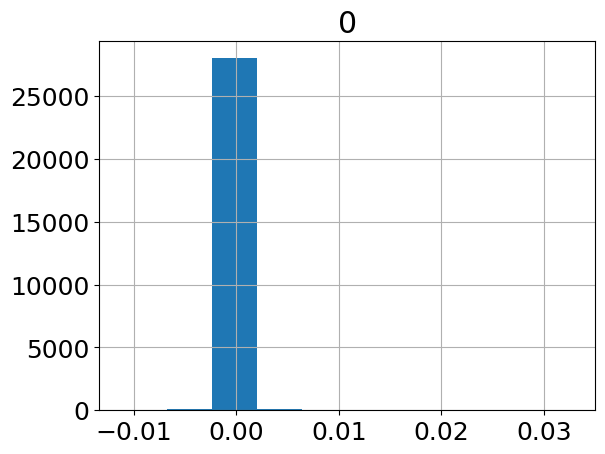

In [49]:
pd.DataFrame(disease_data_mon.mean()).hist()

In [50]:
list(disease_data_mon.mean().sort_values(ascending=False).index[0:20])

['IFI27',
 'S100A8',
 'IFITM3',
 'S100A9',
 'S100A12',
 'RNASE2',
 'CTSD',
 'FOS',
 'CCL3',
 'CD14',
 'CXCL2',
 'IFI6',
 'MAFB',
 'FOSB',
 'CLU',
 'PLBD1',
 'STAB1',
 'GADD45B',
 'TRAPPC5',
 'IFITM2']

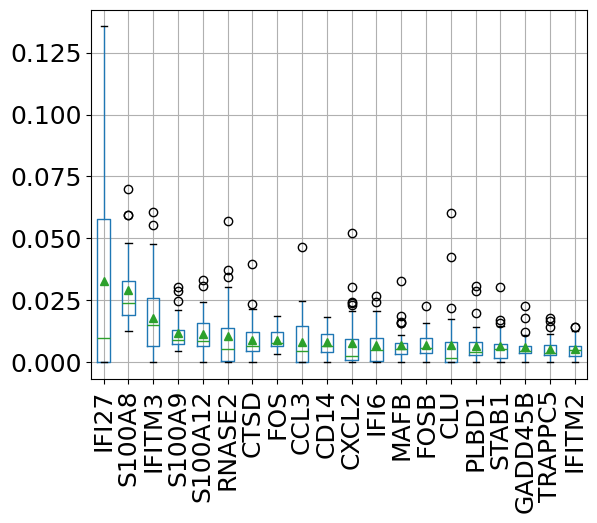

In [51]:
import matplotlib.pyplot as plt
plt.figure()
disease_data_mon.boxplot(column=list(disease_data_mon.mean().sort_values(ascending=False).index[0:20]), showmeans=True )
plt.xticks(rotation=90)
plt.show()

In [52]:
# #for each cell
# disease_data_mon = disease_data[disease_data['cell_type'] == 'CD14-positive monocyte']
# disease_data_mon = disease_data_mon.loc[:, ~disease_data_mon.columns.isin(['cell_type', 'condition', 'patient'])]


# for each patient
disease_data_mon = disease_data[disease_data['cell_type'] == 'platelet']
disease_data_mon = disease_data_mon.loc[:, ~disease_data_mon.columns.isin(['cell_type', 'condition'])]
disease_data_mon = disease_data_mon.groupby('patient').mean()

disease_data_mon.columns = scd.data_module.gene_order

In [53]:
list(disease_data_mon.mean().sort_values(ascending=False).index[0:20])

['IFI27',
 'HBB',
 'CA1',
 'HBD',
 'TUBB4B',
 'GMPR',
 'CLU',
 'SPARC',
 'HBM',
 'IFITM3',
 'FERMT3',
 'DMTN',
 'SLC25A37',
 'TRIM58',
 'HBA1',
 'TMEM40',
 'BEX3',
 'CA2',
 'AHSP',
 'ESAM']

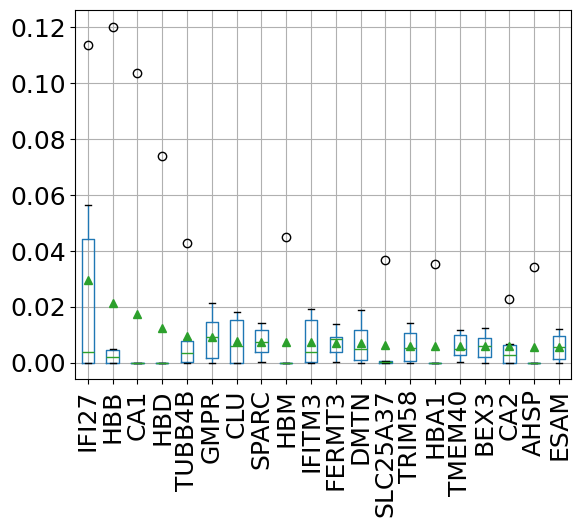

In [54]:
import matplotlib.pyplot as plt
plt.figure()
disease_data_mon.boxplot(column=list(disease_data_mon.mean().sort_values(ascending=False).index[0:20]) , showmeans=True)
plt.xticks(rotation=90)
plt.show()